In [2]:
from soma import aims 
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.morphology import skeletonize_3d
import networkx as nx
import pandas as pd 
from scipy.spatial.distance import euclidean

In [3]:
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')
subj_id = 'CC00063AN06'
session_id = 15102

#subj_id = 'CC00065XX08'
#session_id = 18600

### Setting up the reassign of the mislabels from the opposite hemisphere

In [4]:
### segmentation
R_labels = [15, 67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101,103,105,107,109,111,113,121]
L_labels = [16, 68, 70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,122]

In [146]:
def get_main_graph(subj_id, session_id, hemi):
    
    if hemi == 'left':
        h = 'L'
    else:
        h = 'R'
        
    # inDATA 
    iLabel = aims.read('../../DerivedData/subjects/sub-{}/ses-{}/sub-{}_ses-{}_{}_texture_cortex_voronoi_majority.gii'.format(subj_id, session_id,subj_id, session_id,   hemi))
    iMesh = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_anat_pipeline/sub-{}/ses-{}/anat/sub-{}_ses-{}_T2w_{}white_bv_transformed.gii'.format(subj_id, session_id,subj_id, session_id,  h))
    iCing = aims.read('../../DerivedData/subjects/sub-{}/ses-{}/sub-{}_ses-{}_hemi-{}_pathKmeans_128.label.gii'.format(subj_id, session_id,subj_id, session_id,  hemi))

    
    segm = np.array(iLabel)[0][:].ravel()
    vert, poly = np.array(iMesh.vertex()) ,np.array(iMesh.polygon())
    cing = np.array(iCing)[0][:].ravel()

    ## this should be done after removing cingulate area
    cing_l = np.unique(cing)[-1]
    segm[cing == cing_l] = 0

    ## first, for every polygon create edges: 
    edges = [(edge[0], edge[1]) for edge in poly]
    edges.extend([(edge[1], edge[2]) for edge in poly])
    edges.extend([(edge[2], edge[0]) for edge in poly])

    ## for every edge compute weight based on euclidean distance 
    wg_edges = [(edge[0], edge[1], np.round(euclidean(vert[edge[0]], vert[edge[1]]),3)) for edge in edges]

    G = nx.Graph()
    nodes = [(i, {'label' : segm[i]}) for i in range(len(vert))]
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(wg_edges)
    
    return G, segm


def correct_hemi(G, segm, to_remove):
    
    '''params:
    G: wm graph 
    segm: segmentation array
    to_remove: labels to look for and relabel
    
    To speed up, this does work per 'blob' rather than vertex-by-vertex which might lead to some small errors based on 
    distance but significantly speeds up the runtime
    
    '''
    
    ## find blobs
    for label in to_remove:
        
        # to create subgraph with only those labels
        to_keep = [node for node in G.nodes() if G.node[node]['label'] == label]
        H = G.subgraph(to_keep)
        
        # get connected elements and list of blobs to relabel
        connected = list(nx.connected_components(H))
        for blob in connected:
            # get random vertex from the blob to find the closes new label based on path 
            rpr = np.random.choice(list(blob))
            
            length = nx.single_source_dijkstra_path_length(G, rpr)
            ar = [[key, dji] for key, dji in zip(length.keys(), length.values())]
            ar.sort(key = lambda x: int(x[1]))
            
            for point in ar:
        
                if G.node[point[0]]['label'] not in to_remove :
                    inNum = G.node[point[0]]['label']
                    #print('Blob new label:', inNum)
                    break
            
            ## relabel whole blob 
            print('Size of blob: ', len(list(blob)), 'previous label:', label, 'new label:', inNum)
            segm[list(blob)[:]] = inNum
            
    ## return new segmentation and re-labelled graph 
    ### need to relabel graph with new segmentation!!! 
    new = dict(zip(range(len(segm)), segm))
    nx.set_node_attributes(G, 'label', new)
    
    print(np.unique(segm))
        
    return G, segm 



def relabel_blobs(G, segm, ths=20):
    
    labels = np.unique(segm)[1:]
    for label in labels:
        # to create subgraph
        to_keep = [node for node in G.nodes() if G.node[node]['label'] == label]
        H = G.subgraph(to_keep)
        
        # get connected elements and list of blobs to relabel
        connected = list(nx.connected_components(H))
        sizes = [(len(sub) * 100.)/len(H.nodes()) for sub in connected]
        remove_blobs = []
        for i, size in enumerate(sizes):
            if size < ths:
                remove_blobs.append(connected[i])
                
        ## get new label per blob to speed the stuff up
        for blob in remove_blobs:
            rpr = np.random.choice(list(blob))
    
            length = nx.single_source_dijkstra_path_length(G, rpr)
            ar = [[key, dji] for key, dji in zip(length.keys(), length.values())]
            ar.sort(key = lambda x: int(x[1]))
    
            for point in ar:
        
                if G.node[point[0]]['label'] != G.node[rpr]['label'] :
                    inNum = G.node[point[0]]['label']
                    #print('Blob new label:', inNum)
                    break
            
            ## relabel whole blob 
            print('Size of blob: ', len(list(blob)), 'previous label:', label, 'new label:', inNum)
            segm[list(blob)[:]] = inNum
    
    ### need to relabel graph with new segmentation!!! 
    new = dict(zip(range(len(segm)), segm))
    nx.set_node_attributes(G, 'label', new)
    
    return G, segm 


In [185]:
# get the initial graph & segmentation
G, in_segm = get_main_graph(subj_id=subj_id, session_id=session_id, hemi='right')
newG, new_segm = correct_hemi(G=G.copy(), segm=in_segm.copy(), to_remove=L_labels)

outG, out_segm = relabel_blobs(G=newG.copy(), segm=new_segm.copy(), ths=15)

for i in range(5):
    outG, out_segm = relabel_blobs(G=outG.copy(), segm=out_segm.copy(), ths=15)

outG, out_segm = relabel_blobs(G=outG.copy(), segm=out_segm.copy(), ths=50)

('Size of blob: ', 5, 'previous label:', 68, 'new label:', 87)
('Size of blob: ', 26, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 63, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 1, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 6, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 2, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 3, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 5, 'previous label:', 68, 'new label:', 79)
('Size of blob: ', 2, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 6, 'previous label:', 68, 'new label:', 67)
('Size of blob: ', 2, 'previous label:', 78, 'new label:', 77)
('Size of blob: ', 1, 'previous label:', 78, 'new label:', 77)
('Size of blob: ', 40, 'previous label:', 88, 'new label:', 0)
('Size of blob: ', 1, 'previous label:', 88, 'new label:', 87)
('Size of blob: ', 90, 'previous label:', 112, 'new label:', 111)
('Size of blob: ', 11, 'previous label:', 112, 'ne

('Size of blob: ', 25, 'previous label:', 107, 'new label:', 91)
('Size of blob: ', 1, 'previous label:', 107, 'new label:', 109)
('Size of blob: ', 1, 'previous label:', 107, 'new label:', 111)
('Size of blob: ', 1, 'previous label:', 107, 'new label:', 105)
('Size of blob: ', 1, 'previous label:', 107, 'new label:', 95)
('Size of blob: ', 8, 'previous label:', 109, 'new label:', 113)
('Size of blob: ', 53, 'previous label:', 111, 'new label:', 105)
('Size of blob: ', 69, 'previous label:', 111, 'new label:', 113)
('Size of blob: ', 3, 'previous label:', 111, 'new label:', 107)
('Size of blob: ', 1, 'previous label:', 111, 'new label:', 107)
('Size of blob: ', 1, 'previous label:', 113, 'new label:', 111)
('Size of blob: ', 1, 'previous label:', 113, 'new label:', 111)
('Size of blob: ', 1, 'previous label:', 121, 'new label:', 93)
('Size of blob: ', 14, 'previous label:', 121, 'new label:', 93)
('Size of blob: ', 1, 'previous label:', 121, 'new label:', 71)
('Size of blob: ', 1, 'pre

In [186]:
pre = np.unique(in_segm)[1:]
post = np.unique(out_segm)[1:]

In [187]:
pre_res = {}
for label in pre: 
    pre_res[label] = []
    # to create subgraph with only those labels
    to_keep = [node for node in G.nodes() if G.node[node]['label'] == label]
    H = G.subgraph(to_keep)
    
    for component in list(nx.connected_components(H)):
            pre_res[label].append(len(component)*100./len(to_keep))
            
post_res = {}
for label in post: 
    post_res[label] = []
    # to create subgraph with only those labels
    to_keep = [node for node in outG.nodes() if outG.node[node]['label'] == label]
    H = outG.subgraph(to_keep)
    
    for component in list(nx.connected_components(H)):
            post_res[label].append(len(component)*100./len(to_keep))

In [188]:
def get_error(d):
    error = 0 
    for key in d.keys():
        for el in d[key]:
            error = error + (100-el)
    return error

In [189]:
print('Pre:',get_error(pre_res))
print('Post:',get_error(post_res))

('Pre:', 14300.000000000004)
('Post:', 0.0)


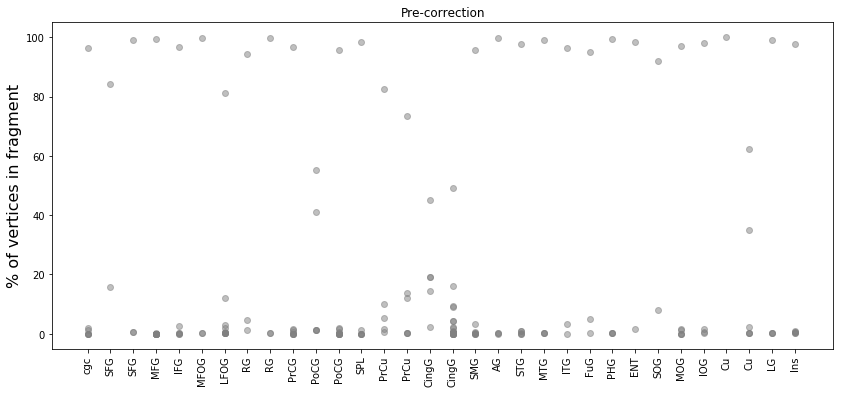

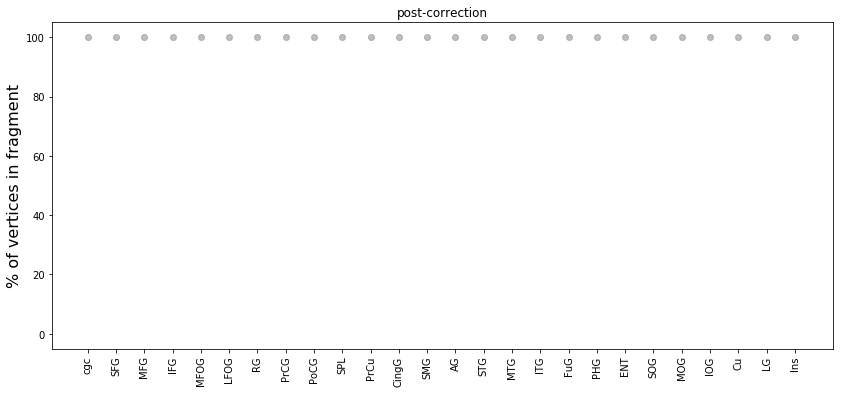

In [184]:
fig, ax = plt.subplots(figsize=(14,6))

for i, label in enumerate(pre):
    x = np.empty_like(np.array(pre_res[label]))
    x[:] = i
    
    ax.scatter(x, pre_res[label], c='gray', alpha=0.5)
ax.set_xticks(range(len(np.unique(pre))))
labels = [item.get_text() for item in ax.get_xticklabels()]


names = [scheme[scheme.Label == label]['Abbreviation\xc2\xa0'].values[0] for label in np.unique(pre)]
names = [ word.encode('ascii', 'replace').split('?')[0] for word in names]

labels[:] = names
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(-5,105)
#ax.set_xticklabels(np.unique(segm)[1:])
#plt.scatter([res[label] for label in np.unique(segm)[1:]], )
ax.set_title('Pre-correction')
ax.set_ylabel('% of vertices in fragment', fontsize=16)
plt.show()


#### post coorection
fig, ax = plt.subplots(figsize=(14,6))

for i, label in enumerate(post):
    x = np.empty_like(np.array(post_res[label]))
    x[:] = i
    
    ax.scatter(x, post_res[label], c='gray', alpha=0.5)
ax.set_xticks(range(len(np.unique(post))))
labels = [item.get_text() for item in ax.get_xticklabels()]


names = [scheme[scheme.Label == label]['Abbreviation\xc2\xa0'].values[0] for label in np.unique(post)]
names = [ word.encode('ascii', 'replace').split('?')[0] for word in names]

labels[:] = names
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(-5,105)
#ax.set_xticklabels(np.unique(segm)[1:])
#plt.scatter([res[label] for label in np.unique(segm)[1:]], )
ax.set_title('post-correction')
ax.set_ylabel('% of vertices in fragment', fontsize=16)
plt.show()

In [190]:
mesh = aims.read('/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_anat_pipeline/sub-{}/ses-{}/anat/sub-{}_ses-{}_T2w_{}white_bv_transformed.gii'.format(subj_id, session_id,subj_id, session_id,  'R'))
vert, poly = np.array(mesh.vertex()) ,np.array(mesh.polygon())
tex = aims.TimeTexture('FLOAT')
for i in range(mesh.size()):
    tex[i].assign(np.zeros((len(vert),), dtype=np.float32))
    t = np.asarray(tex[i])
    t[:] = out_segm[:]
aims.write(tex, 'right_{}_{}.gii'.format(subj_id, session_id))